# 05 - CNN Baseline

In questo notebook addestriamo un **modello CNN baseline** per la classificazione delle immagini di rifiuti.

**Obiettivi:**
- usare la pipeline `tf.data` definita in `src`
- addestrare una CNN semplice come baseline
- valutare le prestazioni su validation e test set

Questo modello rappresenta il primo vero modello “image-based” del progetto,
da confrontare con la baseline lineare (logistic regression)

#### 0) Import librerie e moduli progetto e setup path

Effettuo le seguenti operazioni a partire da:
- `src/garbagecls/db.py`
- `src/garbagecls/paths.py`
- `src/garbagecls/dataset.py`

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name.lower() == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset


#### 1.0) Caricamento dati da DB e creazione dei 3 dataset con label_id

In [ ]:
load_env()

df = read_images_df(source="raw_flat")
df_train, df_val, df_test = split_dfs(df)

label2id, id2label = build_label_maps(df["label"].unique())
num_classes = len(label2id)

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

print(f"num_classes: {num_classes}")
print(f"num_train: {len(df_train)}")
print(f"num_val: {len(df_val)}")
print(f"num_test: {len(df_test)}\n")

print(df_train.head())

num_classes: 6
num_train: 1768
num_val: 379
num_test: 380

   image_id                                  filepath      label  split  \
0         1       data/raw_flat/plastic/plastic92.jpg    plastic  train   
1         2  data/raw_flat/cardboard/cardboard305.jpg  cardboard  train   
2         3   data/raw_flat/cardboard/cardboard53.jpg  cardboard  train   
3         4   data/raw_flat/cardboard/cardboard42.jpg  cardboard  train   
4         5          data/raw_flat/metal/metal141.jpg      metal  train   

   width  height  channels    source  label_id  
0    512     384         3  raw_flat         4  
1    512     384         3  raw_flat         0  
2    512     384         3  raw_flat         0  
3    512     384         3  raw_flat         0  
4    512     384         3  raw_flat         2  


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


#### 1.1) Creazione tensori a partire dai df

In [10]:
IMG_SIZE = (192, 256)
BATCH_SIZE = 32
SEED = 42

train_ds = make_dataset(
    df_train, training=True,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=True
)

val_ds = make_dataset(
    df_val, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

test_ds = make_dataset(
    df_test, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)


print(f'numero di classi: {num_classes}')
print(f'numero di immagini di train: {len(df_train)}')
print(f'numero di immagini di val: {len(df_val)}')
print(f'numero di immagini di test: {len(df_test)}')

numero di classi: 6
numero di immagini di train: 1768
numero di immagini di val: 379
numero di immagini di test: 380


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030846596..1.0384171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.083854616..1.0250053].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0082014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.028188407..1.0197728].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13380349..1.0127888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0010344982..1.001786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.00962

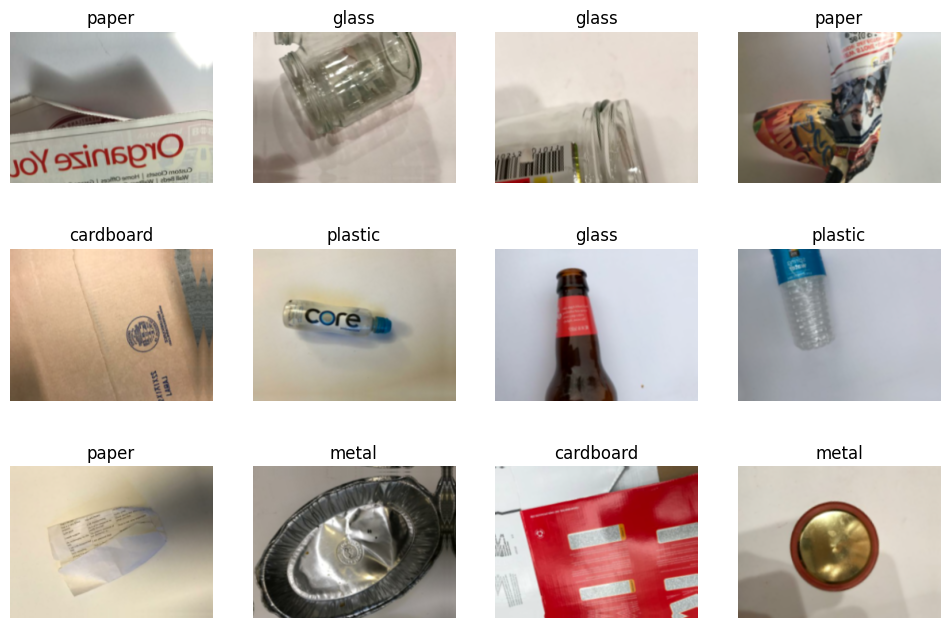

In [8]:
# Visualizziamo un batch di immagini

def show_batch(ds, n=12):
    x, y = next(iter(ds))
    plt.figure(figsize=(12, 8))
    for i in range(n):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(x[i].numpy())
        plt.title(id2label[y[i].numpy()])
        plt.axis("off")
    plt.show()

show_batch(train_ds)


In [11]:
# Quick sanity-check: verify dataset structure and batch shapes
print("train_ds:", train_ds)
print("val_ds  :", val_ds)
print("test_ds :", test_ds)

for xb, yb in train_ds.take(1):
    print("One batch X shape:", xb.shape, "| dtype:", xb.dtype)
    print("One batch y shape:", yb.shape, "| dtype:", yb.dtype)


train_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
val_ds  : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
test_ds : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
One batch X shape: (32, 192, 256, 3) | dtype: <dtype: 'float32'>
One batch y shape: (32,) | dtype: <dtype: 'int32'>


#### 2) Definizione CNN baseline

In [12]:
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 190, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 93, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 84480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,813,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,907,590 (41.61 MB)

 Trainable params: 10,907,590 (41.61 MB)

 Non-trainable params: 0 (0.00 B)

#### 3) Compilazione e training modello  
Sono inseriti un early stopping ed un modulo per dimezzare il LR quando val loss non migliora (può aiutare a portare piccoli miglioramenti e sbloccare il training)

In [20]:
# cartella per salvare i modelli
MODELS_DIR = Path.cwd().parent / "models"   # notebook in /notebooks -> parent è la repo root
MODELS_DIR.mkdir(exist_ok=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

EPOCHS = 30  # alte: tanto ci pensa l'early stopping

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,                # 5 era troppo alto
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,                # dimezza LR quando val_loss non migliora
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint_path = MODELS_DIR / "cnn_baseline_best.keras"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

print()
print("Best model saved at:", checkpoint_path)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5908 - loss: 1.1115
Epoch 1: val_loss improved from None to 1.11003, saving model to c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_best.keras

Epoch 1: finished saving model to c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.5962 - loss: 1.0610 - val_accuracy: 0.5778 - val_loss: 1.1100 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6585 - loss: 0.9597
Epoch 2: val_loss improved from 1.11003 to 1.06327, saving model to c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_best.keras

Epoch 2: finished saving model to c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 415ms/step - accuracy: 0.6476 - loss: 0.9614 - val_accuracy: 0.5699 - val_loss: 1.0633 - learning_rate: 0.0010
Epoch 3/30
56

#### 4) Valutazione sul test set

In [21]:
test_loss, test_acc = model.evaluate(test_ds) #test_ds_our in sostituzione quando verrà aggiunto
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6763 - loss: 1.0986
Test accuracy: 0.6763 | Test loss: 1.0986


#### Salvataggio modello

In [22]:
# === Save model + metadata (baseline CNN) ===
# We save:
# 1) best checkpoint (updated during training) -> models/cnn_baseline_best.keras
# 2) a timestamped copy for reproducibility -> models/cnn_baseline_<stamp>.keras
# 3) a small JSON sidecar with training settings + final metrics

import json
import datetime
from pathlib import Path
from tensorflow import keras

PROJECT_ROOT = Path.cwd().parent  # notebook in /notebooks
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

stamp = datetime.datetime.now().strftime("%Y-%m%d-%H%M%S")

best_path = MODELS_DIR / "cnn_baseline_best.keras"
archive_path = MODELS_DIR / f"cnn_baseline_{stamp}.keras"
meta_path = MODELS_DIR / f"cnn_baseline_{stamp}.json"

# Load the best checkpoint to be 100% sure we are saving/evaluating the best weights
best_model = keras.models.load_model(best_path)

# Save timestamped archive
best_model.save(archive_path)

# Build metadata (history is a keras.callbacks.History object)
info = {
    "model_name": "cnn_baseline",
    "model_file": archive_path.name,
    "best_checkpoint": best_path.name,
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "seed": SEED,
    "epochs_trained": len(history.history.get("loss", [])),
    "final_train_acc": float(history.history.get("accuracy", [None])[-1]),
    "final_val_acc": float(history.history.get("val_accuracy", [None])[-1]),
    "final_train_loss": float(history.history.get("loss", [None])[-1]),
    "final_val_loss": float(history.history.get("val_loss", [None])[-1]),
}

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(info, f, indent=2)

print("✅ Saved:")
print(" - best checkpoint:", best_path)
print(" - archived model  :", archive_path)
print(" - metadata json   :", meta_path)


✅ Saved:
 - best checkpoint: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_best.keras
 - archived model  : c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_2026-0206-141452.keras
 - metadata json   : c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_2026-0206-141452.json


#### CARICO EVENTUALMENTE IL MODELLO

In [24]:
from tensorflow import keras
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / "cnn_baseline_2026-0206-141452.keras"  # esempio

print("Loading model from:", model_path)
model = keras.models.load_model(model_path)
model.summary()

print("Model loaded successfully.")

Loading model from: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_2026-0206-141452.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 190, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 93, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 84480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,813,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,722,772 (124.83 MB)

 Trainable params: 10,907,590 (41.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,815,182 (83.22 MB)

Model loaded successfully.


#### 5) Curve di training

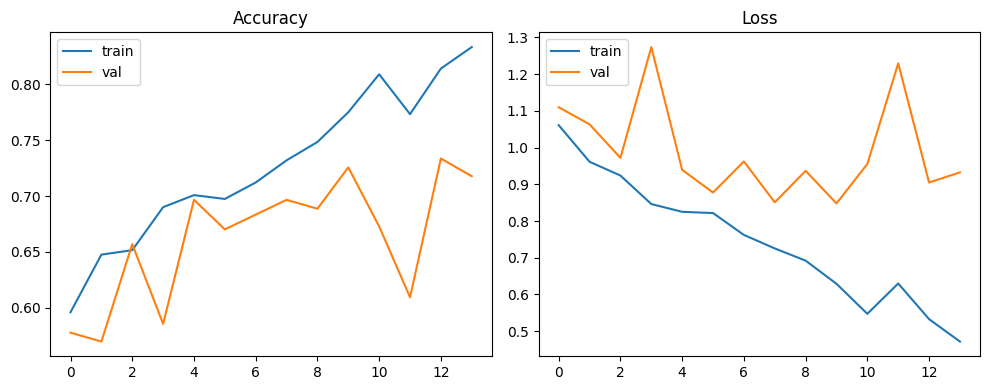

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


**Train accuracy** cresce in modo regolare, mentre **validation accuracy** si stabilizza presto intorno a 0.60. Quindi il modello impara ma tendo ad un leggero overfitting, ma non collassa la curva val, quindi modello stabile.

**Train loss** descresce costantemente, mentre **validation loss** non lo fa in modo così marcato. Potremmo introdurre un early stopping

#### 6) Classification Report con Confusion Matrix

              precision    recall  f1-score   support

   cardboard     0.8276    0.8000    0.8136        60
       glass     0.7000    0.5526    0.6176        76
       metal     0.5181    0.6935    0.5931        62
       paper     0.7750    0.6966    0.7337        89
     plastic     0.6173    0.6849    0.6494        73
       trash     0.6667    0.6000    0.6316        20

    accuracy                         0.6763       380
   macro avg     0.6841    0.6713    0.6732       380
weighted avg     0.6904    0.6763    0.6786       380



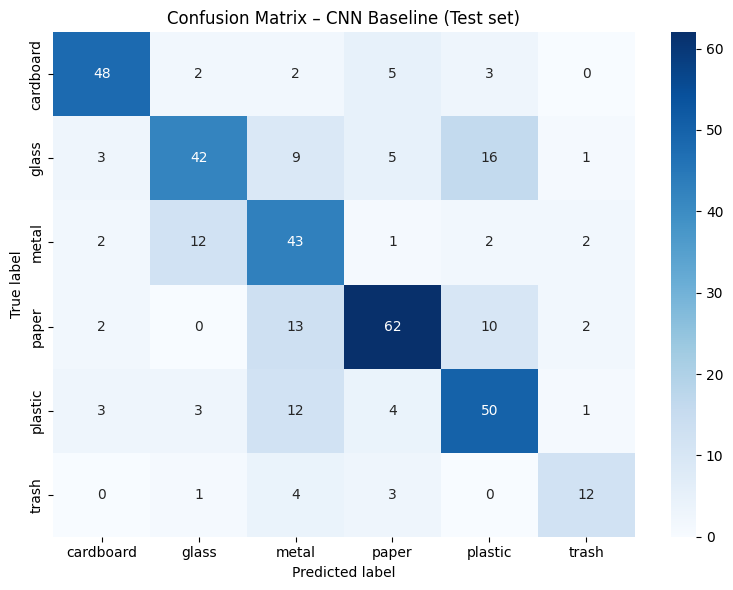

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predizioni sul test set (BEST model)
y_true, y_pred = [], []

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds)

# Classification report
labels = [id2label[i] for i in range(len(id2label))]
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – CNN Baseline (Test set)")
plt.tight_layout()
plt.show()


La **riga** di fatto ci mostra la `recall`, ovvero tra tutte quelle davvero della classe X, quante ne becco.

La **colonna** invece ci indica la `precision`, ovvero di quelle che ho predetto X, quante davvero lo sono.

**ESEMPIO:** Per *glass* ho una buona precision (0.70), ma una recall inferiore (0.55)


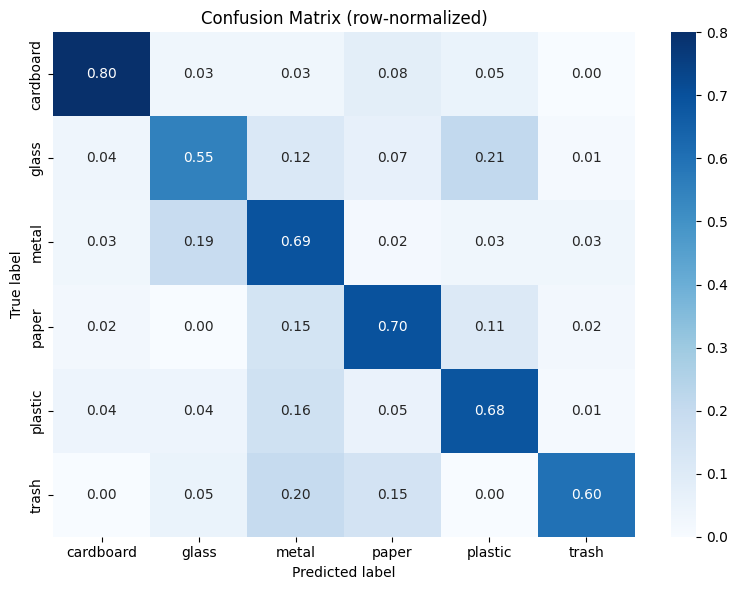

In [26]:
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()


## Considerazioni

- La CNN sfrutta la struttura spaziale delle immagini, a differenza della baseline lineare.

- Le prestazioni risultano migliori rispetto alla logistic regression raggiungendo un test accuracy di circa il 67% (rispetto al 35% della logistic regression). In particolare:  
  - Le curve di val e train mostrano un apprendimento stabile con leggero overfitting indicando che la pipeline e lo split dei dati è avvenuto in modo corretto.  
  - La confusion matrix evidenzia un buon risultato con cardboard, paper, ma evidenzia anche confusione sistematica con materiali simili (plastic vs paper, glass vs metal) suggerendo ulteriore lavoro per migliorare le performance.

- Questo modello costituisce un punto di partenza per:
  - architetture più profonde
  - transfer learning (es. MobileNet, ResNet)
